<a href="https://colab.research.google.com/github/FelixDeMan/DLVU/blob/master/wip_backbone_projects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Notebook Introduction

Welcome to the main project notebook! 

## What is the goal of this notebook?

This notebook should contain your project write-up and the analyses conducted on the provided data. For each project, the notebook provides links to a few articles on the subject of the notebook, and a few examples of analyses that you could/should do. But it is not at all exhaustive: If you need to install more python packages or other software, do so. If you want to search for additional literature to support your writing, do so!

Your goal is to work from these examples towards answering the list of questions specific to each of the projects, and write a coherent report following the structure at the bottom of this notebook. Your colleagues (and I) will read and grade the result. So, make sure that you provide ample and adequate descriptions of your results and methodologies. This notebook is likely going to get rather large as you add analyses, so best to use markdown cells and headings to create a table of contents structure, as you can see in the ToC menu on the left of the Colab user interface.  

If this project feels a bit open-ended, that's because it is - just like actual research! ***But you are not alone!*** You will collaborate with your fellow students in your group! I also want to push you towards asking any and all questions in the canvas discussions, and directly to me via email and the Friday Zoom meetings. I'm here to help, and will give hints if you ask me the right questions. 

You are free to make this as beautiful and far-reaching as you feel like. But keep track of time, you will need to finish this the week before the exam. Perfect is the enemy of good, beware. 


## Installation etc.

The first part of this notebook is shared across the different projects, as the notebook will download the data for all the projects in the same way. 

The first installation and setup cells may take a little while to run as they fetch and install all the required software. It's also likely there's going to be a LOT of outputs that are irrelevant. Feel free to delete the output of this cell after it runs to free up space. 

In [1]:
# this cell installs some dependencies. 
# feel free to disregard the output this generates

!apt -qq install inkscape > /dev/null
!pip -qq install nibabel nilearn
!pip -qq install git+https://github.com/gallantlab/pycortex.git#egg=pycortex



Extracting templates from packages: 100%
     |████████████████████████████████| 10.1 MB 6.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
# after these basic installs, we can import our required packages. 

import numpy as np
import scipy as sp
import nibabel as nb
import nilearn as nl
from nilearn.surface import load_surf_data
import os, shutil, urllib.request

from matplotlib import rc
rc('animation', html='jshtml')

import matplotlib.pyplot as plt
%matplotlib inline 

### Download of data: surfaces for plotting and project data

Both the surface data we'll use for visualization and the project fMRI data are on figshare. From Figshare, we can download the data and place them in the Colab virtual machine. You don't have to read/understand this code - it's all boilerplate stuff to set up Colab's virtual machine so that it works with our data. 

***More important:*** For a brief description of the data of the different projects, --and a couple of very important parameters of these acquisitions which you will need later-- please consult the [figshare website](https://figshare.com/articles/dataset/fMRI_Teaching_Materials/14096209)

In [4]:
#
# this cell ensures that we can work with our own surface from within the colab environment
#

os.makedirs('/content/pycortex/db', exist_ok=True)
os.makedirs('/content/pycortex/colormaps', exist_ok=True)
os.makedirs('/content/data', exist_ok=True)

wrong_filestore_location = 'build/bdist.linux-x86_64/wheel/pycortex-1.3.0.dev0.data/data/share/pycortex/'
with open('/usr/local/lib/python3.7/dist-packages/cortex/defaults.cfg', 'r') as f:
  file_source = f.read()
replace_string = file_source.replace(wrong_filestore_location, '/content/pycortex/') #save output 
with open('/usr/local/lib/python3.7/dist-packages/cortex/defaults.cfg', 'w') as f:
  f.write(replace_string)   

os.chdir('/tmp/')
!git clone https://github.com/gallantlab/pycortex.git
!cp /tmp/pycortex/filestore/colormaps/* /content/pycortex/colormaps/

#
# and we'll download our average hcp subject for pycortex visualization
#

pycortex_sj_URL = "https://ndownloader.figshare.com/files/25768841"

urllib.request.urlretrieve(pycortex_sj_URL, os.path.join('/content/pycortex/db', 'hcp_999999.zip'))
!unzip -qq /content/pycortex/db/hcp_999999.zip -d /usr/share/pycortex/db/

#
# and then download the projects' data from figshare
#

timeseries_data_URL = 'https://ndownloader.figshare.com/articles/14096209/versions/3'
urllib.request.urlretrieve(timeseries_data_URL, os.path.join('/content/data', '14096209.zip'))
!unzip -qq /content/data/14096209.zip -d /content/data/
!unzip -qq /content/data/hrf_mapper_59k.zip -d /content/data/hrf_mapper_59k/
!unzip -qq /content/data/prf_mapper_59k.zip -d /content/data/prf_mapper_59k/
!unzip -qq /content/data/soma_mapper_59k.zip -d /content/data/soma_mapper_59k/
!unzip -qq /content/data/atlas.zip -d /content/data/

Cloning into 'pycortex'...
remote: Enumerating objects: 23877, done.
remote: Counting objects: 100% (2281/2281), done.
remote: Compressing objects: 100% (770/770), done.
remote: Total 23877 (delta 1526), reused 2157 (delta 1452), pack-reused 21596
Receiving objects: 100% (23877/23877), 476.15 MiB | 24.54 MiB/s, done.
Resolving deltas: 100% (18208/18208), done.


## Putting these tools to first use

Ok, why all this complicated hassle? Well, we want you to have a playground that allows you to really get to know the data. 

#### Where are the data files?

The data have now been downloaded, and you can check out the data on disk by using the command line. For example, in a code cell you can preface the line with an exclamation mark to give a commandline command: 

`!ls /content/data/prf_mapper_59k`

Will give you the contents of the prf experiment data folder. But, on the left in the CoLab UI you can also find a file navigator, next to the table of contents, search and code snippet elements. Feel free to have a look around!

#### Okay, but what can we do with these tools?

After downloading and auto-editing the data required for working with pycortex, we can now import pycortex. We'll use pycortex for plotting of the results, which is using only a subset of its awesome features. Remember that [brain viewer of semantic maps](http://gallantlab.org/huth2016/)? Also made using pycortex! If you have some spare time and want to play around with this awesome package, please have a look at the [pycortex docs](https://gallantlab.github.io/pycortex/)

In [7]:
!ls /content/data/prf_mapper_59k

sub-02_task-prf_space-59k_hemi-L_run-median_desc-bold.func.gii	vis_design.mat
sub-02_task-prf_space-59k_hemi-R_run-median_desc-bold.func.gii


In [6]:
import cortex as cx

And, just to highlight the type of visualisation we'll be doing, a quick demo of the way we'll be using it. We'll be using the surface from the Human Connectome Project, which we named `hcp_999999`. So that's the 'subject' name we use to get and plot surface data using pycortex. 

Don't worry if you see a bunch of warnings and stuff - it will create the figure we asked for from what is in essence a single line of code: the curvature of the cortical surface of this standard surface. **Gorgeous!** 

Feel free to change the datatype to `'thickness'`, for example. Also **Gorgeous!**

Generating a flatmap cache
Failed to get connection
** (inkscape:3217): CRITICAL **: 13:07:38.421: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3217): CRITICAL **: 13:07:38.421: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3217): CRITICAL **: 13:07:38.421: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed


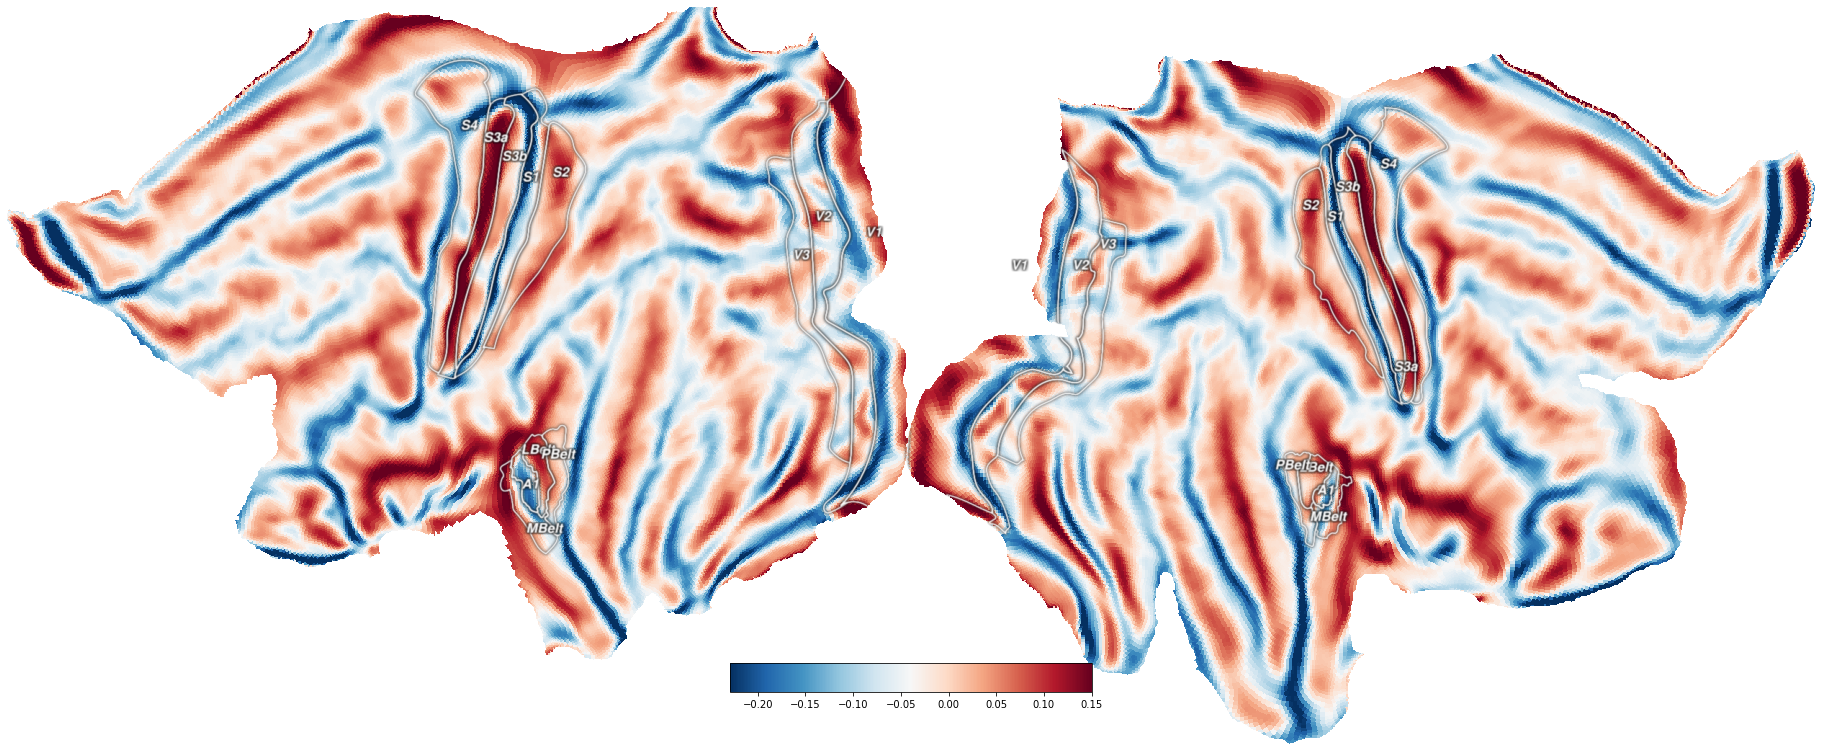

In [8]:
curv_vertices = cx.db.get_surfinfo(subject='hcp_999999', type='curvature')

cx.quickshow(curv_vertices);

### Flatmaps?

But what the hell are we looking at, even? The cortical surface or ribbon is topologically a ball per hemisphere. That is, each hemisphere can be inflated to the shape of a sphere (let's not get stuck on the question how a hemisphere can also be a sphere :-) ). Flatmaps are created by cutting the inflated cortical surface at specific locations (see the black lines in the left figure), and then letting the computer flatten the resulting mesh into a planar surface. 

<img src="https://github.com/VU-Cog-Sci/wiki/raw/master/imgs/flatten/image9.png" alt="where do we cut the surface" width="45%" style="align:left;"/> <img src="https://universe-review.ca/I10-13-BrainMap3.jpg" alt="Visual, auditory and somatosensory brain regions" width="45%" style="align:right;"/>

This flatmapping has the advantage that we can view the entire cerebral cortex in one fell swoop, but the downside is that it is hard to orient yourself to where things are. That's why we've added some lines that surround certain labeled regions of interest - they are the visual, auditory and somatosensory/motor cortex. In the right image they are the blue, red and green areas of the brain, respectively. We're using exactly the flattened surfaces of the right column in the right figure, but ours are rendered side-by-side. Recognize them from the curvature figure?

Take a few minutes to orient yourself on these surfaces, using the atlas in the right figure. Where are the darker areas of this atlas on the inflated surfaces, and where do they end up on the flattened surface? Same for the coloured regions - make sure you have an idea of where things are. This will greatly increase your maneuverability in the brain. 

You'll need that maneuverability because we'll be working with surface data in this project: all the data you will load is surface-based, and should be visualized as shown in this introduction. In many ways, surface-based fMRI data is simpler than volume-based data. Instead of 4-dimensional, it's 2-dimensional: vertices by timepoints. This makes it less of a bookkeeping hassle to use. Let's have a look at some of your fMRI time-course data!


## Loading the functional data for your project

In the cell below we're loading the functional MRI files you'll be working with. There's a different set of files that you open and read depending on the project that you'll be doing. Once loaded, though, all of these datasets have the same format - they're all formatted for the same surface that you've already plotted data into. 

In [10]:
# Here, I'm using python's awesome f-string functionality to load the data in a structured way across hemisperes. 
# Once the data have been loaded (for plotting and stuff), we don't have to care about hemispheres so much anymore. 
# There are 3 separate versions here, one for each project-dataset.


#########################################################################################################
###############
############### pRF mapping data
###############
#########################################################################################################

tseries_raw = np.nan_to_num(np.concatenate([load_surf_data(
         os.path.join('/content/data/prf_mapper_59k', f'sub-02_task-prf_space-59k_hemi-{hemi}_run-median_desc-bold.func.gii'))
          for hemi in ['L', 'R']]))

#########################################################################################################
###############
############### somatotopic mapping data
###############
#########################################################################################################

#tseries_raw = np.concatenate([load_surf_data(
#        os.path.join('/content/data/soma_mapper_59k', f'sub-01_ses-01_task-soma_run-median_space-59k_hemi-{hemi}_sg_psc.dtseries.gii'))
#         for hemi in ['L', 'R']])

#########################################################################################################
###############
############### hrf mapping data
###############
#########################################################################################################

# tseries_raw = np.concatenate([load_surf_data(
#         os.path.join('/content/data/hrf_mapper_59k', f'sub-012_ses-2_task-hrfmapper_run-1_bold_space-T1w_preproc_59k.{hemi}.dtseries.gii'))
#          for hemi in ['L', 'R']])


# and, we'll check the shape of the data to see whether things make sense
# data should be shaped as vertices by timepoints, and each hemisphere is 59k vertices - hence the name :) 
print(tseries_raw.shape)

(118584, 120)


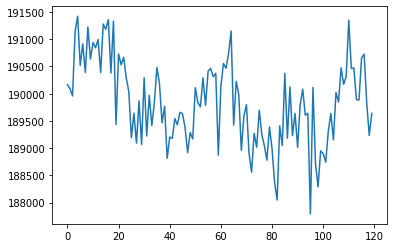

In [11]:
import matplotlib.pyplot as plt

plt.plot(tseries_raw[1,:])

In [73]:
from scipy import stats

ts_normalized = stats.zscore(tseries_raw, axis  = 0)
print(np.mean(ts_normalized))
np.std(ts_normalized)



5.951216e-10


1.0000001

HIGH PASS FILTERING

The `gaussian_filter` function takes two mandatory input: some kind of (n-dimensional) signal and a cutoff, "sigma", that refers to the width of the gaussian filter in standard deviations. "What? We decided to define our cutoff in seconds (or, equivalently, Hz), right?", you might think. For some reason neuroimaging packages seem to define cutoff for their temporal filters in **seconds** while more 'low-level' filter implementations (such as in scipy) define cutoffs (of gaussian filters) in **the width of the gaussial filter**, i.e., **sigma**. Fortunately, there is an easy way to (approximately) convert a cutoff in seconds to a cutoff in sigma, given a particular TR (in seconds):

\begin{align}
\sigma \approx \frac{\mathrm{cutoff}_{sec}}{2 \cdot \mathrm{TR}_{sec}}
\end{align}

<div class='alert alert-warning'>
<b>ToDo</b> 
</div>

Suppose I acquire some fMRI data (200 volumes) with a sampling frequency of 0.25 Hz and I would like to apply a high-pass filter of 80 seconds. What sigma should I choose? Calculate sigma and store it in a variable named `sigma_todo`.

In [71]:
from scipy.ndimage import gaussian_filter

TR = 1.5
sigma_hp = 120 / (2 * TR) 

hpfiltered = np.empty_like(ts_normalized)
for i, sig in enumerate(ts_normalized):
  
  filter = gaussian_filter(sig, sigma_hp)
  hpfiltered[i,:] = sig - filter




In [ ]:
print(tseries_raw)
tseries_raw - filter

[[174289.77  173917.38  174248.47  ... 174451.83  174086.34  174326.25 ]
 [190166.    190094.28  189958.17  ... 189851.12  189235.03  189637.61 ]
 [170052.97  169840.05  170029.69  ... 169556.66  169893.62  169870.83 ]
 ...
 [ 79805.6    79731.23   79369.984 ...  78985.87   79032.98   79386.86 ]
 [ 85643.03   85143.57   84627.695 ...  84915.53   85061.84   85387.4  ]
 [ 90040.77   89799.445  89673.016 ...  88431.516  88913.83   88823.38 ]]


array([[ 89404.984 ,  89032.65  ,  89363.84  , ...,  89670.39  ,
         89304.95  ,  89544.89  ],
       [105305.27  , 105233.61  , 105097.6   , ..., 105093.695 ,
        104477.65  , 104880.25  ],
       [ 85240.24  ,  85027.375 ,  85217.12  , ...,  84847.14  ,
         85184.16  ,  85161.38  ],
       ...,
       [ 15464.801 ,  15390.719 ,  15030.0625, ...,  15465.332 ,
         15512.988 ,  15867.141 ],
       [ 21325.883 ,  20826.715 ,  20311.426 , ...,  21418.203 ,
         21565.059 ,  21890.883 ],
       [ 25735.465 ,  25494.43  ,  25368.586 , ...,  24945.8   ,
         25428.656 ,  25338.48  ]], dtype=float32)

(120,)
(118584, 120)


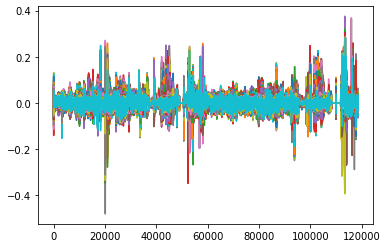

In [72]:
print(filter.shape)
print(hpfiltered.shape)
plt.plot(hpfiltered)

(120,)
(120,)


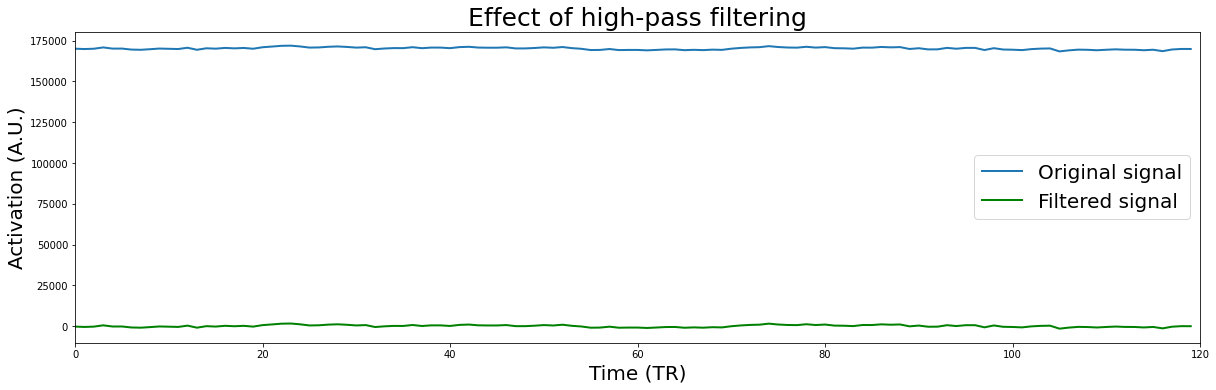

In [37]:
from scipy.ndimage import gaussian_filter

sig = tseries_raw[2,:]

TR = 1.5
sigma_hp = 120 / (2 * TR) 
filt = gaussian_filter(sig, sigma_hp)
print(sig.shape)
print(filt.shape)
plt.figure(figsize=(17, 10))

'''plt.subplot(2, 1, 1)
plt.plot(sig, lw=2)
plt.plot(filt, lw=4)
plt.xlim(0, 200)
plt.legend(['Original signal', 'Low-freq component'], fontsize=20)
plt.title("Estimated low-frequency component using HP-filter", fontsize=25)
plt.ylabel("Activation (A.U.)", fontsize=20)
'''
filt_sig = sig - filt

plt.subplot(2, 1, 2)
plt.plot(sig, lw=2)
plt.plot(filt_sig, lw=2, c='green')
plt.xlim(0, 120)
plt.legend(['Original signal', 'Filtered signal'], fontsize=20)
plt.title("Effect of high-pass filtering", fontsize=25)
plt.xlabel("Time (TR)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)

#plt.plot(filt_sig)

plt.tight_layout()
plt.show()

## Raw Data Observations
### What amount of preprocessing has already been done?

If the signals have been filtered already, there should be no drifts in the data. Also, if the data time-courses have already been z-scored or converted to percent signal change, the mean of the signals should already be 0. If the data are in 'units' of % signal change, the maximal excursions of the signal timecourse will be on the order of 10-20. If they've been z-scored, their standard deviation should be exactly 1 (duh!). 

Like we learned in the preprocessing lecture and practical, the standard deviation over time also gives us a lot of valuable information regarding signal quality in non-z-scored data. Let's have a quick look at these different aspects of the data on flatmaps. This will also show us whether we were scanning the whole brain or not - an aspect of the data acquisition that you may want to mention in your report...

**Note**
If we plot data that didn't come from pycortex's surface data itself, but from our own files, we need to supply a subject. Adding the colormap is just for clarity. 

Failed to get connection
** (inkscape:3842): CRITICAL **: 14:05:28.513: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3842): CRITICAL **: 14:05:28.513: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3842): CRITICAL **: 14:05:28.513: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (inkscape:3845): CRITICAL **: 14:05:29.994: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3845): CRITICAL **: 14:05:29.994: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3845): CRITICAL **: 14:05:29.994: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (inkscape:3848): CRITICAL **: 14:05:31.424: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3848): CRITICAL **: 14:05:31.424: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3848)

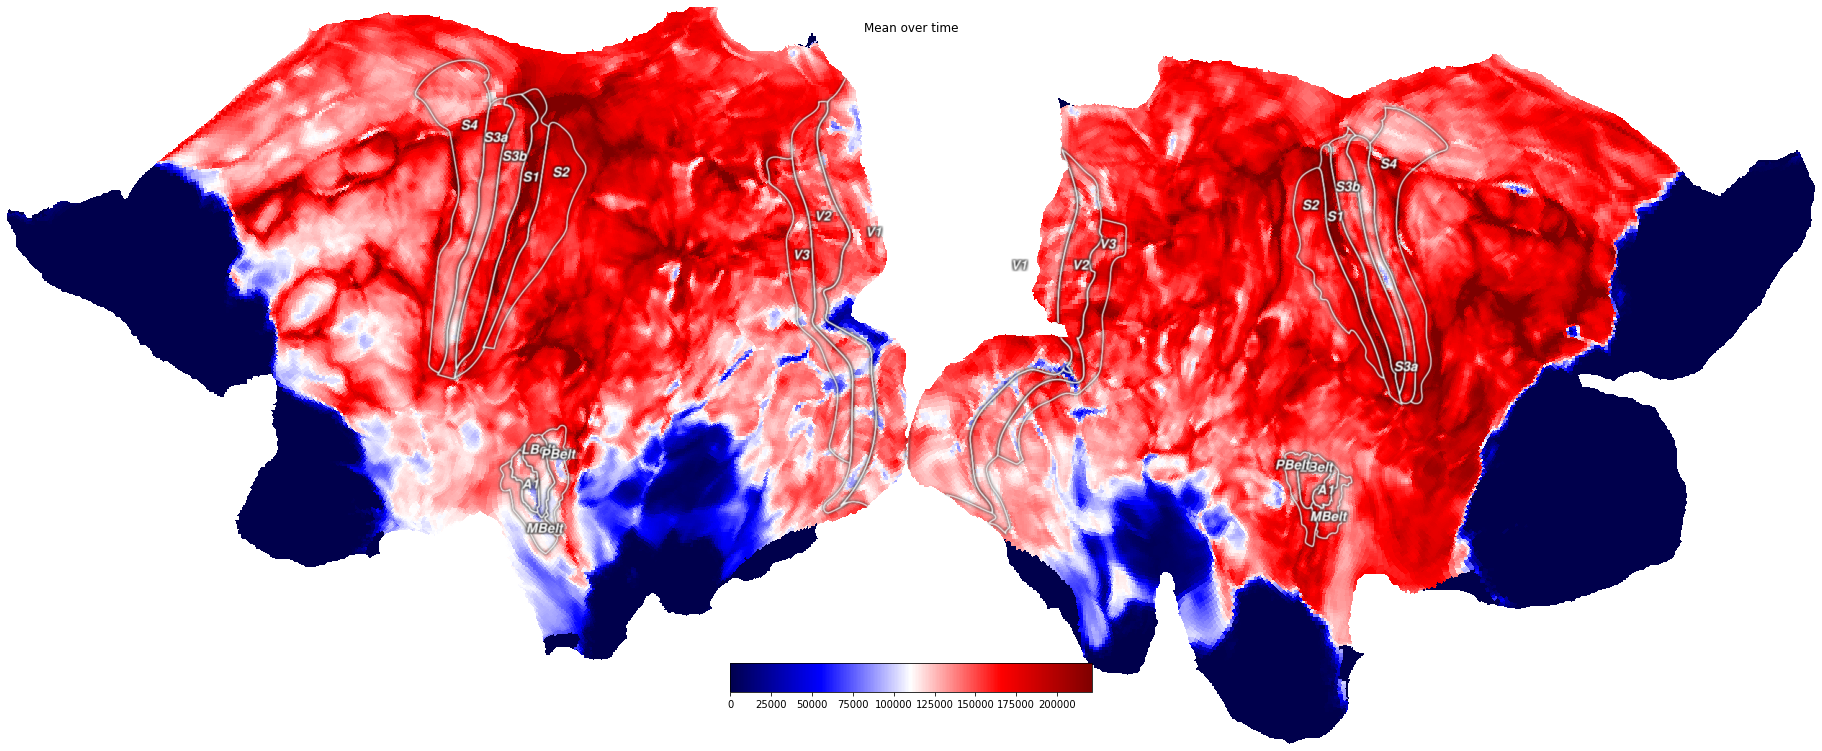

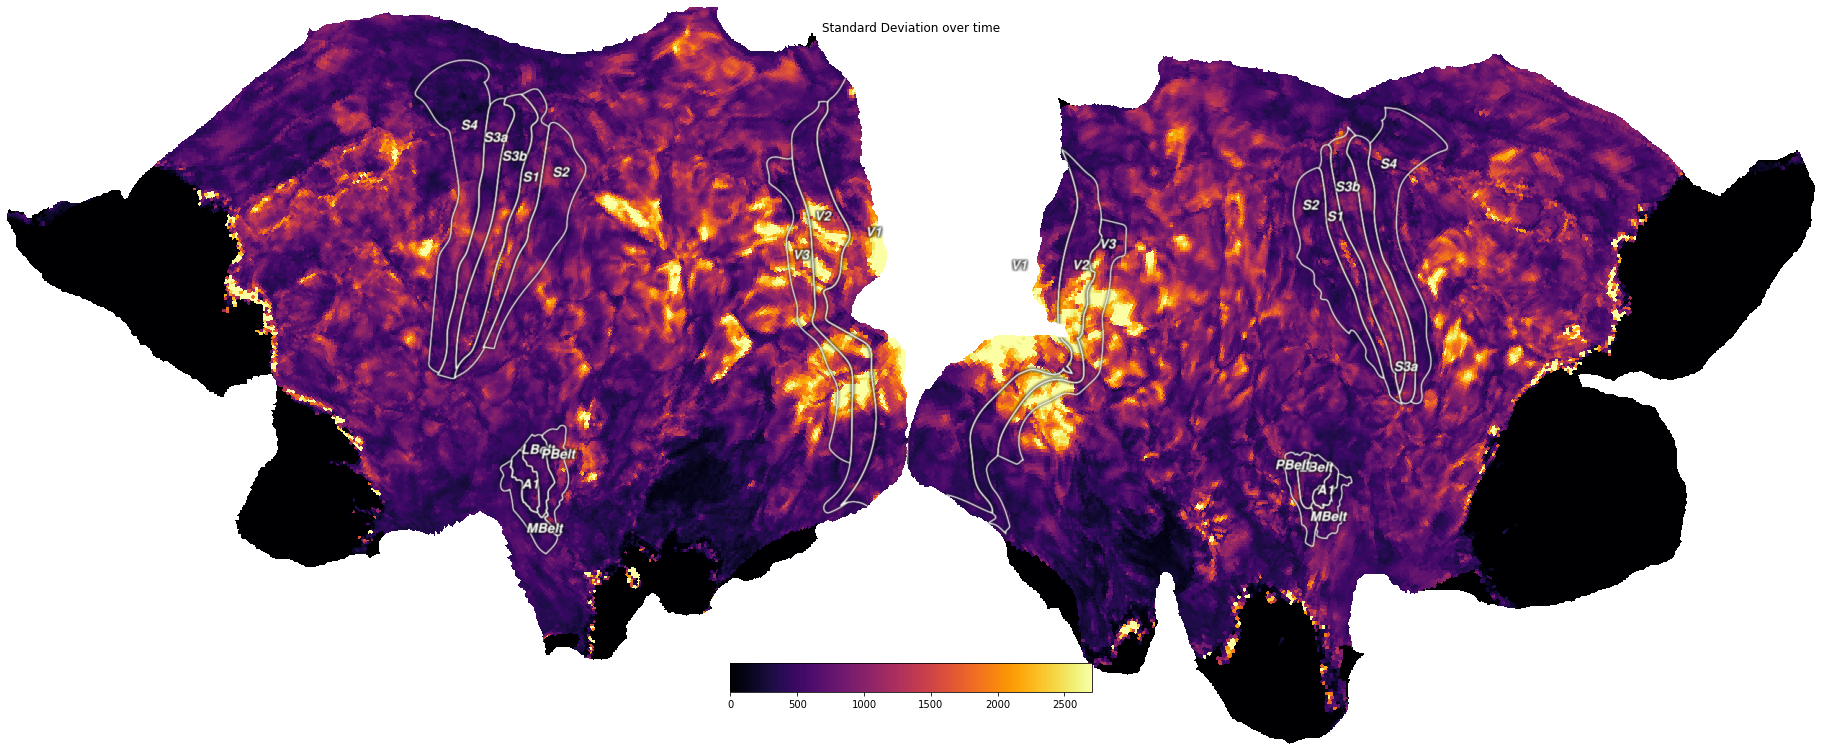

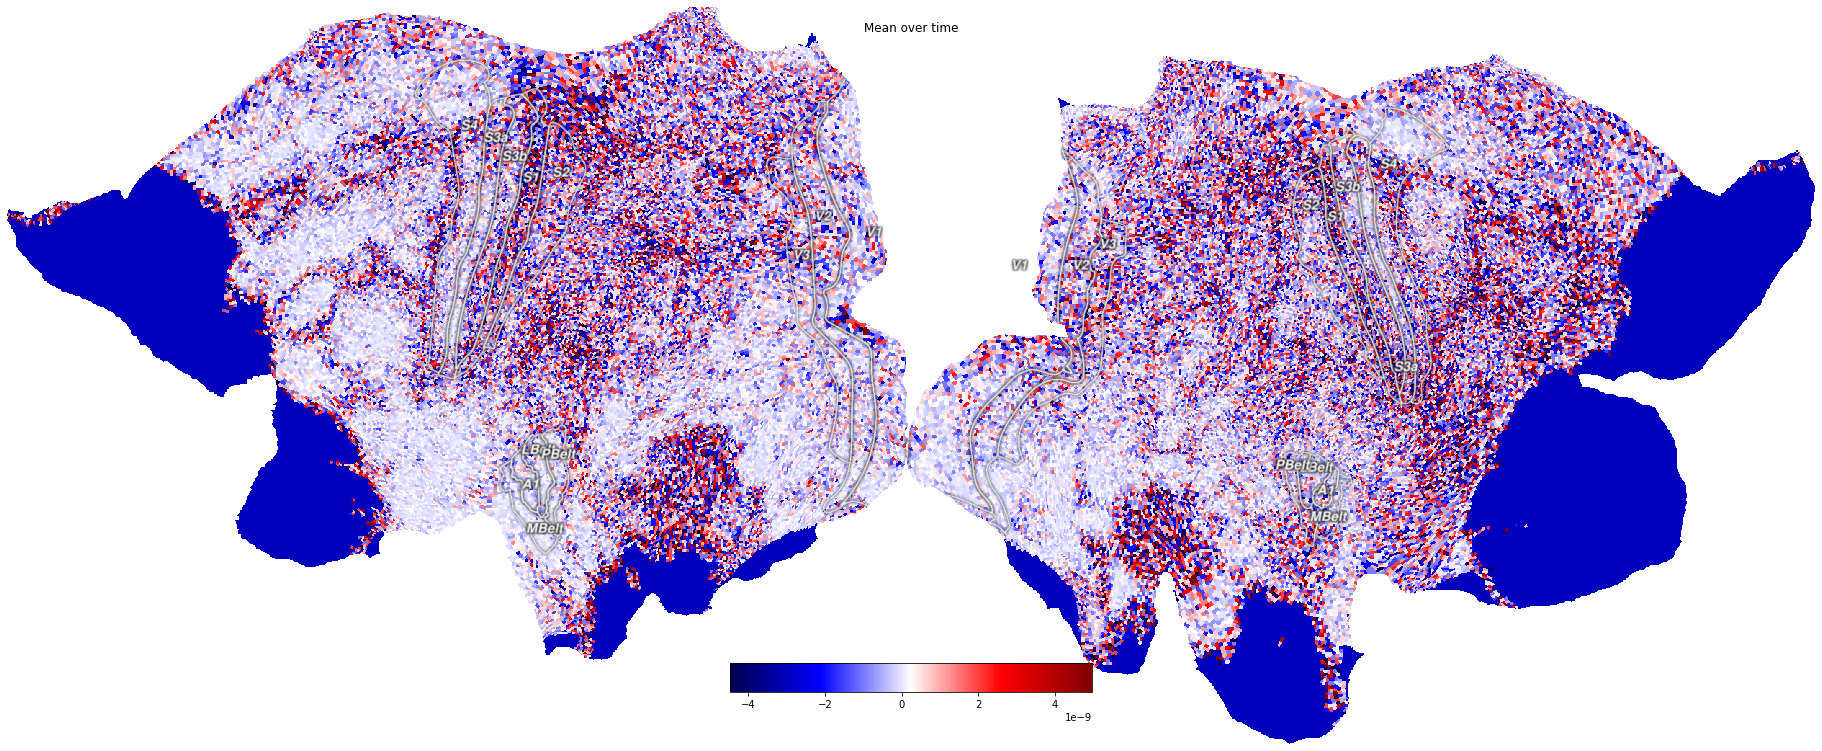

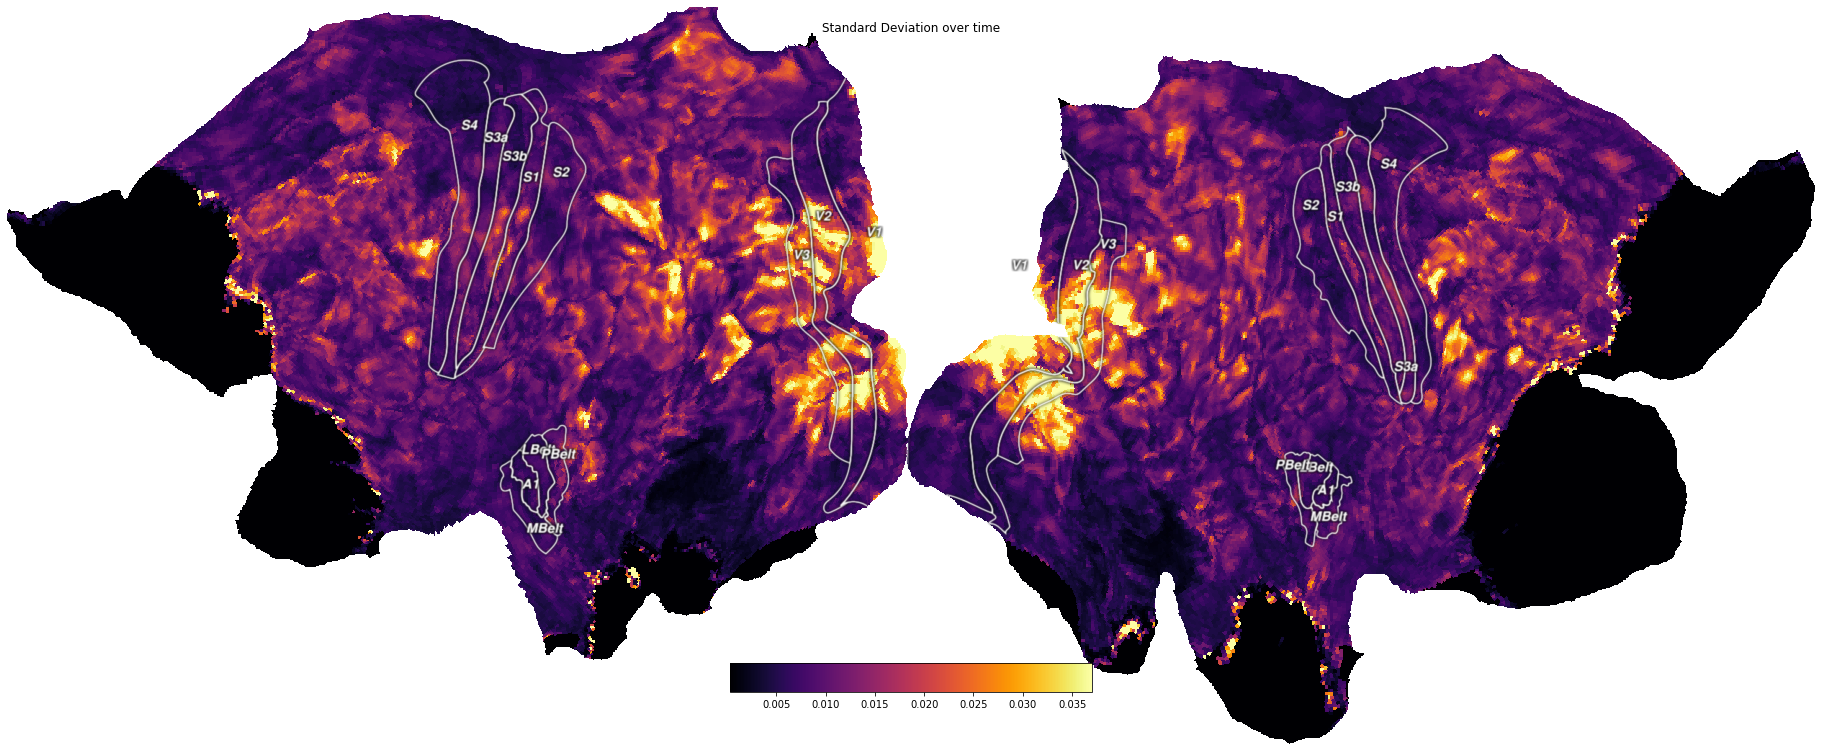

In [74]:
# Note that we saw in the cell above that the second dimension is time, 
# so the axis on which we take the mean and standard deviation is 1
f = cx.quickshow(cx.Vertex(tseries_raw.mean(axis=1), subject='hcp_999999', cmap='seismic'));
f.suptitle('Mean over time')

f = cx.quickshow(cx.Vertex(tseries_raw.std(axis=1), subject='hcp_999999', cmap='inferno'));
f.suptitle('Standard Deviation over time');

f = cx.quickshow(cx.Vertex(hpfiltered.mean(axis=1), subject='hcp_999999', cmap='seismic'));
f.suptitle('Mean over time')

f = cx.quickshow(cx.Vertex(hpfiltered.std(axis=1), subject='hcp_999999', cmap='inferno'));
f.suptitle('Standard Deviation over time');

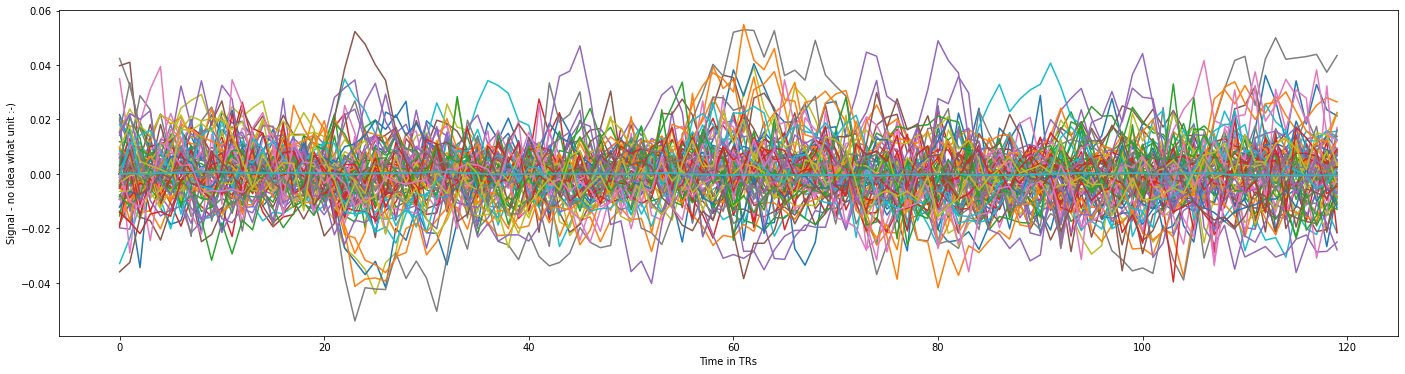

In [86]:
# now, let's get some random time-courses to check whether there's still drift:
random_vertices = np.random.choice(np.arange(hpfiltered.shape[0]), 100)
f = plt.figure(figsize=(24,6))
plt.plot(hpfiltered[random_vertices].T)
plt.xlabel('Time in TRs')
plt.ylabel('Signal - no idea what unit :-)');

Now, depending on your dataset you may see that the top of the brain is brighter than the bottom. This is due to the fact that the top of the brain is closer to the coils. Moreover, you may see some really interesting web-like pattern on the surfaces that you've plotted. Like this:

<img style="float:right; align:right top; margin:10px; padding: 25px 25px 25px 25px;" src="https://i.imgur.com/lqPTAzK.png" alt="Model pipeline" width="500" align="right" />

What is that stuff? Why isn't it homogeneous? The answer is, we're looking at blood, and at 7 Tesla (at which all these data were acquired) these veins show up very strongly. Their presence has a strong influence on whether you can find any 'activation', as they may get in the way of what you want to find. Keep this in mind!

### Questions concerning signal quality

From these simple surface and time-course plots above, we can immediately gather a couple of things. Try to answer the following questions from both the flatmaps and the random time-courses. 

1.   have these data been z-scored or percent signal changed? **Check the colorbars!** What would they look like if they'd been z-scored?
2.   have these data been high-pass filtered? **Check the timecourses!**
3.   where do you see the biggest signal fluctuations? What are the likely origins of these fluctuations? 

You can use these insights in writing the data description section of your report! Note that there are differences between the different project-datasets, so make sure you inspect your own!

<font color='red'>-- Important: --</font>

**Your conclusions about the state of the data for your project will tell you what to do: you now have to decide whether to perform additional preprocessing, such as temporal filtering, percent signal change conversion, etc.**

## Atlas tools

It's a very powerful thing to be able to plot stuff on the entire cerebral cortex in one go. But sometimes you want to focus on a single brain region. You can use your own methods to define regions of interest, for example using a separate mapper experiment that allows you to select voxels/vertices of interest - within which you'll then perform your analysis of interest. 

But we'll use the existing multi-modal parcelation atlas from the Human Connectome Project, from the [Glasser et al Nature study](https://www.nature.com/articles/nature18933) that was mentioned a couple of times in the lectures. This is the atlas shown in the right flatmap figure above, in the 'Flatmaps' section.

The following cells show how to select a given ROI's data - something that you may want to do quite a lot in your own analyses. It serves to zoom into a specific region of interest, but also means that you can 'pilot' time-consuming analyses on smaller amounts of data while still taking care to test your entire analysis. 

In [75]:
# we read in the atlas data, which consists of 180 separate regions per hemisphere. 
# These are labeled separately, so the labels go to 360. 
# To work with them in both hemispheres simultaneously, we mod by 180. 
atlas_data = np.concatenate([load_surf_data(
        os.path.join('/content/data/atlas', f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
         for hemi in ['L', 'R']])
atlas_data_both_hemis = np.mod(atlas_data, 180)

### Selecting an ROI

One can now easily use a test to create boolean arrays into a specific ROI. For example, we can check which ROI is indexed by the number 1. Make sure you understand what I did with the `vmin` and `vmax` settings of the `Vertex` object! You may be able to use these little tricks later!

Failed to get connection
** (inkscape:3858): CRITICAL **: 14:05:45.782: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3858): CRITICAL **: 14:05:45.782: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3858): CRITICAL **: 14:05:45.782: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed


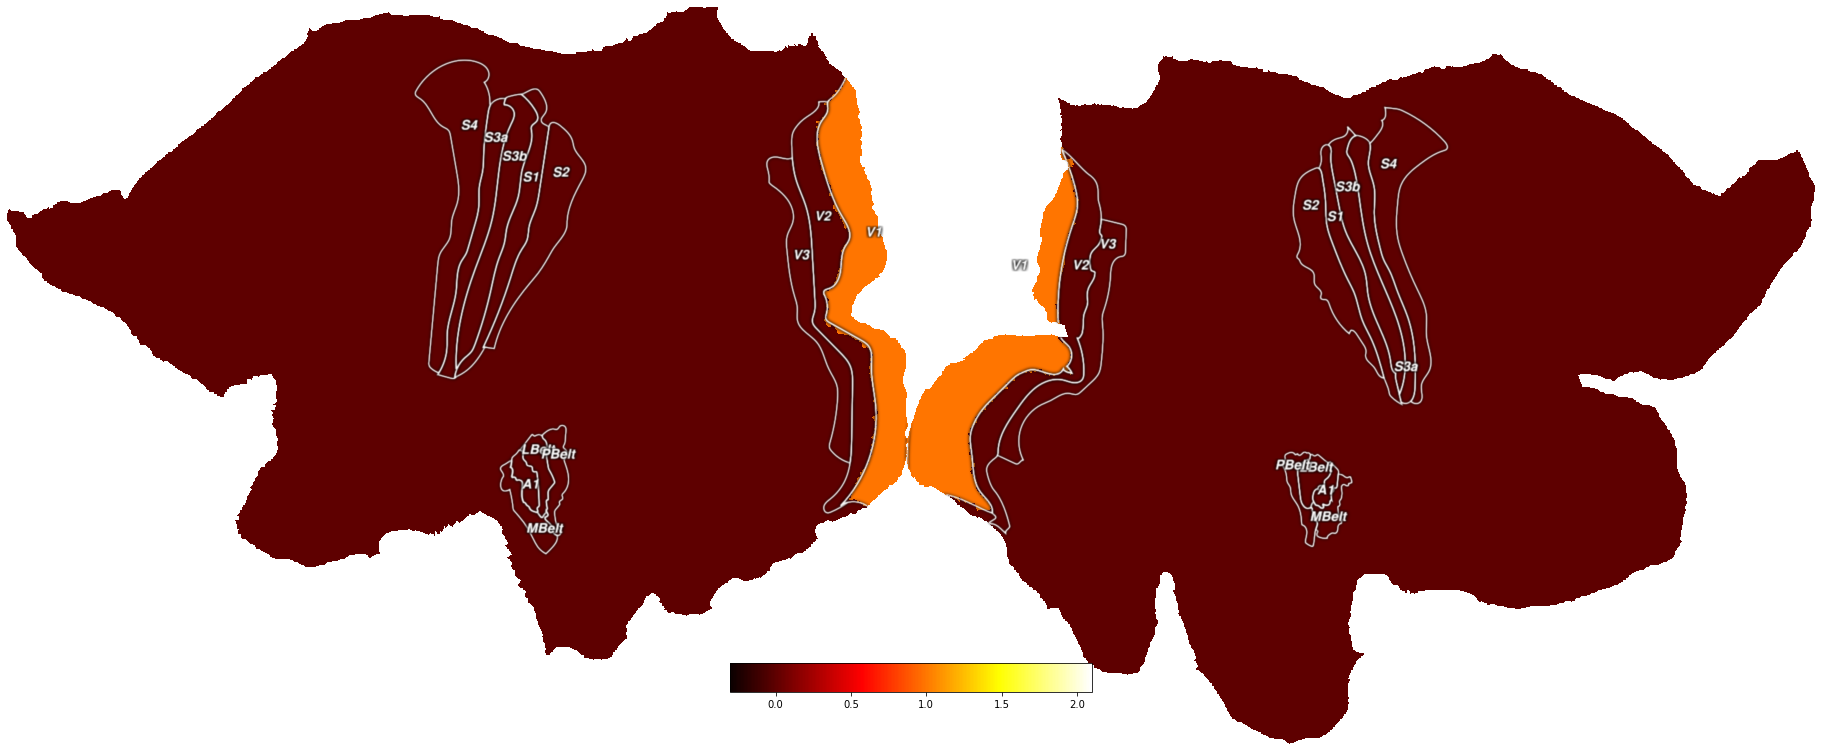

In [76]:
f = cx.quickshow(cx.Vertex(atlas_data_both_hemis == 1, subject='hcp_999999', cmap='hot', vmin=-0.3, vmax=2.1));

This means we can also select those parts of the brain and single out the responses from just a single region of interest! That should be much more manageable. For now, we'll select the region we highlighted above, V1 - the first region of the cortical visual hierarchy. It turns out that 2 out of our 3 experiments did something very very visual, with the third also showing visual stimuli. So let's see what we end up with! Once you've understood the idea of the following code cell, feel free to experiment with the actual index of the ROI this analysis works with!

***Note 1:*** whether this raw data visualization is very informative depends on your experiment. So, don't worry if this doesn't show you anything here. 

***Note 2:*** See how I'm trying to label all my figure axes so that it's clear what the units and elements of the data are? **It's very important that you do the same for your report!**

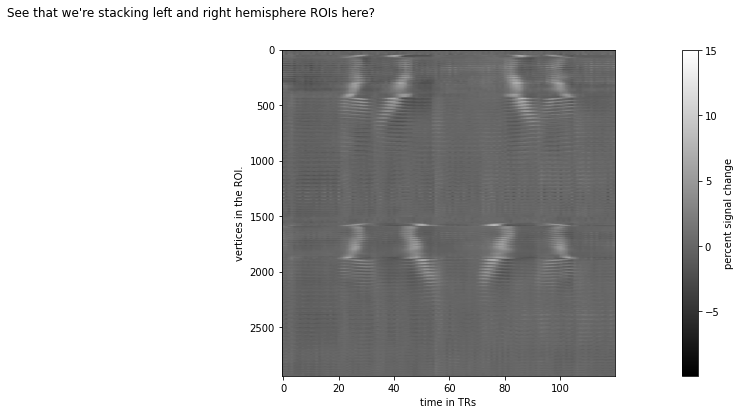

In [43]:
roi_boolean_mask = atlas_data_both_hemis == 1

# but let's look at the actual signals after percent signal change conversion. 
def psc(data):
  """take percent signal change of data along axis 1. 
  This implementation is a bit idiosyncratic since 
  it uses the median instead of the mean of the signal.
  For sparse signals with very strong activations (such as those at 7T)
  this approach makes sense. Can you imagine why?"""
  # crudely checking whether psc hasn't already happened, in which case do nothing
  if np.mean(data) < 0.5:
    return data
  return ((data.T/np.median(data, 1)).T - 1) * 100

f = plt.figure(figsize=(24,6))
plt.imshow(psc(tseries_raw[roi_boolean_mask]), aspect=1/25, cmap='gray')
plt.xlabel('time in TRs')
plt.ylabel('vertices in the ROI.')
plt.colorbar(label='percent signal change')
f.suptitle("See that we're stacking left and right hemisphere ROIs here?");

To help you out a bit, here's a dictionary that gives you the indices in the atlas for the regions that are outlined in the flatmaps. This may help you find your way later on :-)

In [45]:
roi_index_dict = {
    # somatosensory:
    'CS1_4': 8, 'CS2_3a': 53, 'CS3_3b': 9, 'CS4_1': 51, 'CS5_2': 52,
    # auditory:
    'A1': 24, 'PBelt': 124, 'MBelt': 173, 'LBelt': 174, '52': 103, 'RI': 104,
    # low-level visual:
    'V1': 1, 'V2': 4, 'V3': 5,
    # mid-level and high-level visual:
    'V3A': 13, 'V3B': 19, 'IPS1': 17, 'LIPv': 48, 'LIPd': 95, 
    'VIP': 49, 'FEF': 10, 'MST': 2, 'MT': 23, 'LO1': 20, 'LO2': 21, 'LO3': 159
    }

# Project 1: Population Receptive Field Mapping

This section will explain the experiment, background and analysis plans for your project's dataset. You should feel free to use any and all information in this "Project Explanation" section in your own report. 

Before reading this Project Explanation, please read, as a group, the relevant articles: [Population receptive field estimates in human visual cortex, Dumoulin & Wandell, 2008](https://www.spinozacentre.nl/dumoulin/PDFs/Dumoulin-NI-2008.pdf), and [Visual Field Maps in Human Cortex, Brewer, Dumoulin & Wandell, 2007](https://www.cns.nyu.edu/~david/courses/sm12/Readings/Wandell-Neuron2007.pdf). If you have any questions about the type of experiment we're going to be looking at, and the different analysis steps, please ask me. 


<img style="float:right; align:right top; margin:10px; padding: 25px 25px 25px 25px;" src="https://i.imgur.com/ionIYpH.png" alt="Model pipeline" width="300" align="right" />

## Computational Neuroimaging: the pRF Model

The Population Receptive Field (pRF) approach is a nice example of how recently, computational modeling of fMRI BOLD responses has become *the* way to go about analyzing your data. The method and model fit not only into the neuroimaging literature, but extend the idea of the receptive field from single-cell electrophysiology into fMRI. For more background on this, you can look back to the two lecture videos on this topic [here (part 1)](https://youtu.be/LRp1ecAO1HQ) and [here (part 2)](https://youtu.be/t7cslFH1VYg).
 

The basic idea of this approach is that we explicitly model the mechanism that generates our BOLD responses, purely in spatial terms (we could have added features such as orientation, colour, etc, but let's keep it simple for now). This pRF model mathematically describes the region of visual space that a voxel's neural *population* responds to. 

In this case, the model is really elementary; it's a Gaussian function in Cartesian 2-dimensional space. That is, it has a peak location in 2D space, and a width - also in 2 dimensions. This Gaussian is `isotropic`, which just means that it's circular in our 2D space (it could also be elliptical, although recent research shows that a circular, `isotropic` model actually works better). Now, because of our conceptualization of the model the peak location and width of the Gaussian correspond to parameters in our mathematical model. Specifically, our equation for the Gaussian is 
\begin{align*}
  G_*=exp\left(-\frac{(x-x_0)^2+(y-y_0)^2}{2\sigma_*^2}\right), \quad \quad G_*\cdot S \equiv \sum\limits_{x,y} (G_*\circ S),
\end{align*}, 
where $x_0$ and $y_0$ are the horizontal and vertical location of the peak, and $\sigma$ is the width of the pRF's region of activation. 

!! Note that these parameters are stimulus-referred; the
units of x0, y0 and σ are all in degrees of visual angle. !!

Whenever the stimulus is in this Gaussian window, we expect a BOLD response. This notion is implemented by the $G_*\cdot S$ part of the equation, which means that we take the dot product of the stimulus with the spatial profile of the model Gaussian. 

This means that with a few parameters ${x_0, y_0, \sigma}$ and knowing what stimulus we presented when, we can create a model timecourse for the response of the neurons in our voxel - and we can do so at each timepoint of our experiment. Of course, then we have to convolve with the HRF to generate an actual model-predicted BOLD response. By comparing our model-predicted BOLD response to the data, we can vary the parameters of our model (the stimulus remains the same, of course) to find the parameter values that best explain our data. This sequence of steps is outlined in the figure to the right, taken from the original [pRF article](https://www.spinozacentre.nl/dumoulin/PDFs/Dumoulin-NI-2008.pdf). 

The cells below go through these steps in code. 

!The optimal pRF parameters were found by minimizing the
RSS using a two-stage coarse-to-fine search.!

In [46]:
def gauss2D_iso_cart(x, y, mu=(0.0, 0.0), sigma=1.0, normalize_RFs=False):
    """gauss2D_iso_cart
    gauss2D_iso_cart takes two-dimensional arrays x and y, containing
    the x and y coordinates at which to evaluate the 2D isotropic gaussian 
    function, with a given sigma, and returns a 2D array of Z values.
    Parameters
    ----------
    x : numpy.ndarray, 2D or flattened by masking
        2D, containing x coordinates
    y : numpy.ndarray, 2D or flattened by masking
        2D, containing y coordinates
    mu : tuple, optional
        mean, 2D coordinates of mean/mode of gauss (the default is (0.0,0.0))
    sigma : float, optional
        standard deviation of gauss (the default is 1.0)
    Returns 
    -------
    numpy.ndarray, 2D or flattened by masking
        gaussian values evaluated at (x,y)
    """
    if normalize_RFs:
        return np.exp(-((x-mu[0])**2 + (y-mu[1])**2)/(2*sigma**2)) /(2*np.pi*sigma**2)
    else:
        return np.exp(-((x-mu[0])**2 + (y-mu[1])**2)/(2*sigma**2))

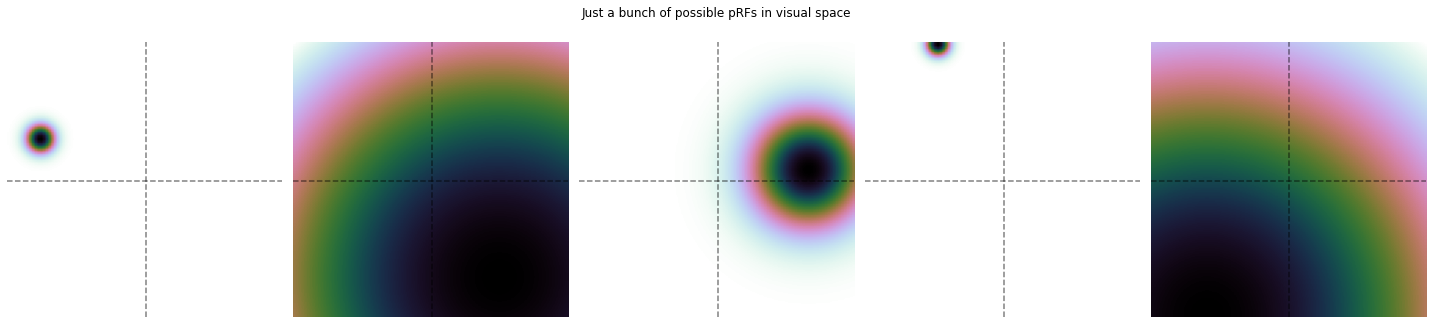

In [77]:
# set up the metrics of visual space
space_1D = np.linspace(-10,10,100,endpoint=True)
X, Y = np.meshgrid(space_1D, space_1D)

f, sps = plt.subplots(1,5,figsize=(20,5))
for i in range(5):
    x0, y0, sigma = -10+np.random.rand()*20, -10+np.random.rand()*20, 0.5 + np.random.exponential()*10
    sps[i].imshow(gauss2D_iso_cart(X, Y, mu=(x0,y0), sigma=sigma, normalize_RFs=False), cmap='cubehelix_r')
    sps[i].axvline(50, color='k', ls='--', alpha=0.5)
    sps[i].axhline(50, color='k', ls='--', alpha=0.5)
    sps[i].axis('off')
f.suptitle('Just a bunch of possible pRFs in visual space');
plt.tight_layout()

Cool, so now we have our pRF model. We can use it to define different receptive field instances by varying these parameters. The next step would be to combine these models with the stimulus (you know, that $G_*\cdot S$ part of the equation above), so that we can create neural model timecourses. Luckily, we have the stimulus that was shown to the subject saved as a convenient file. 

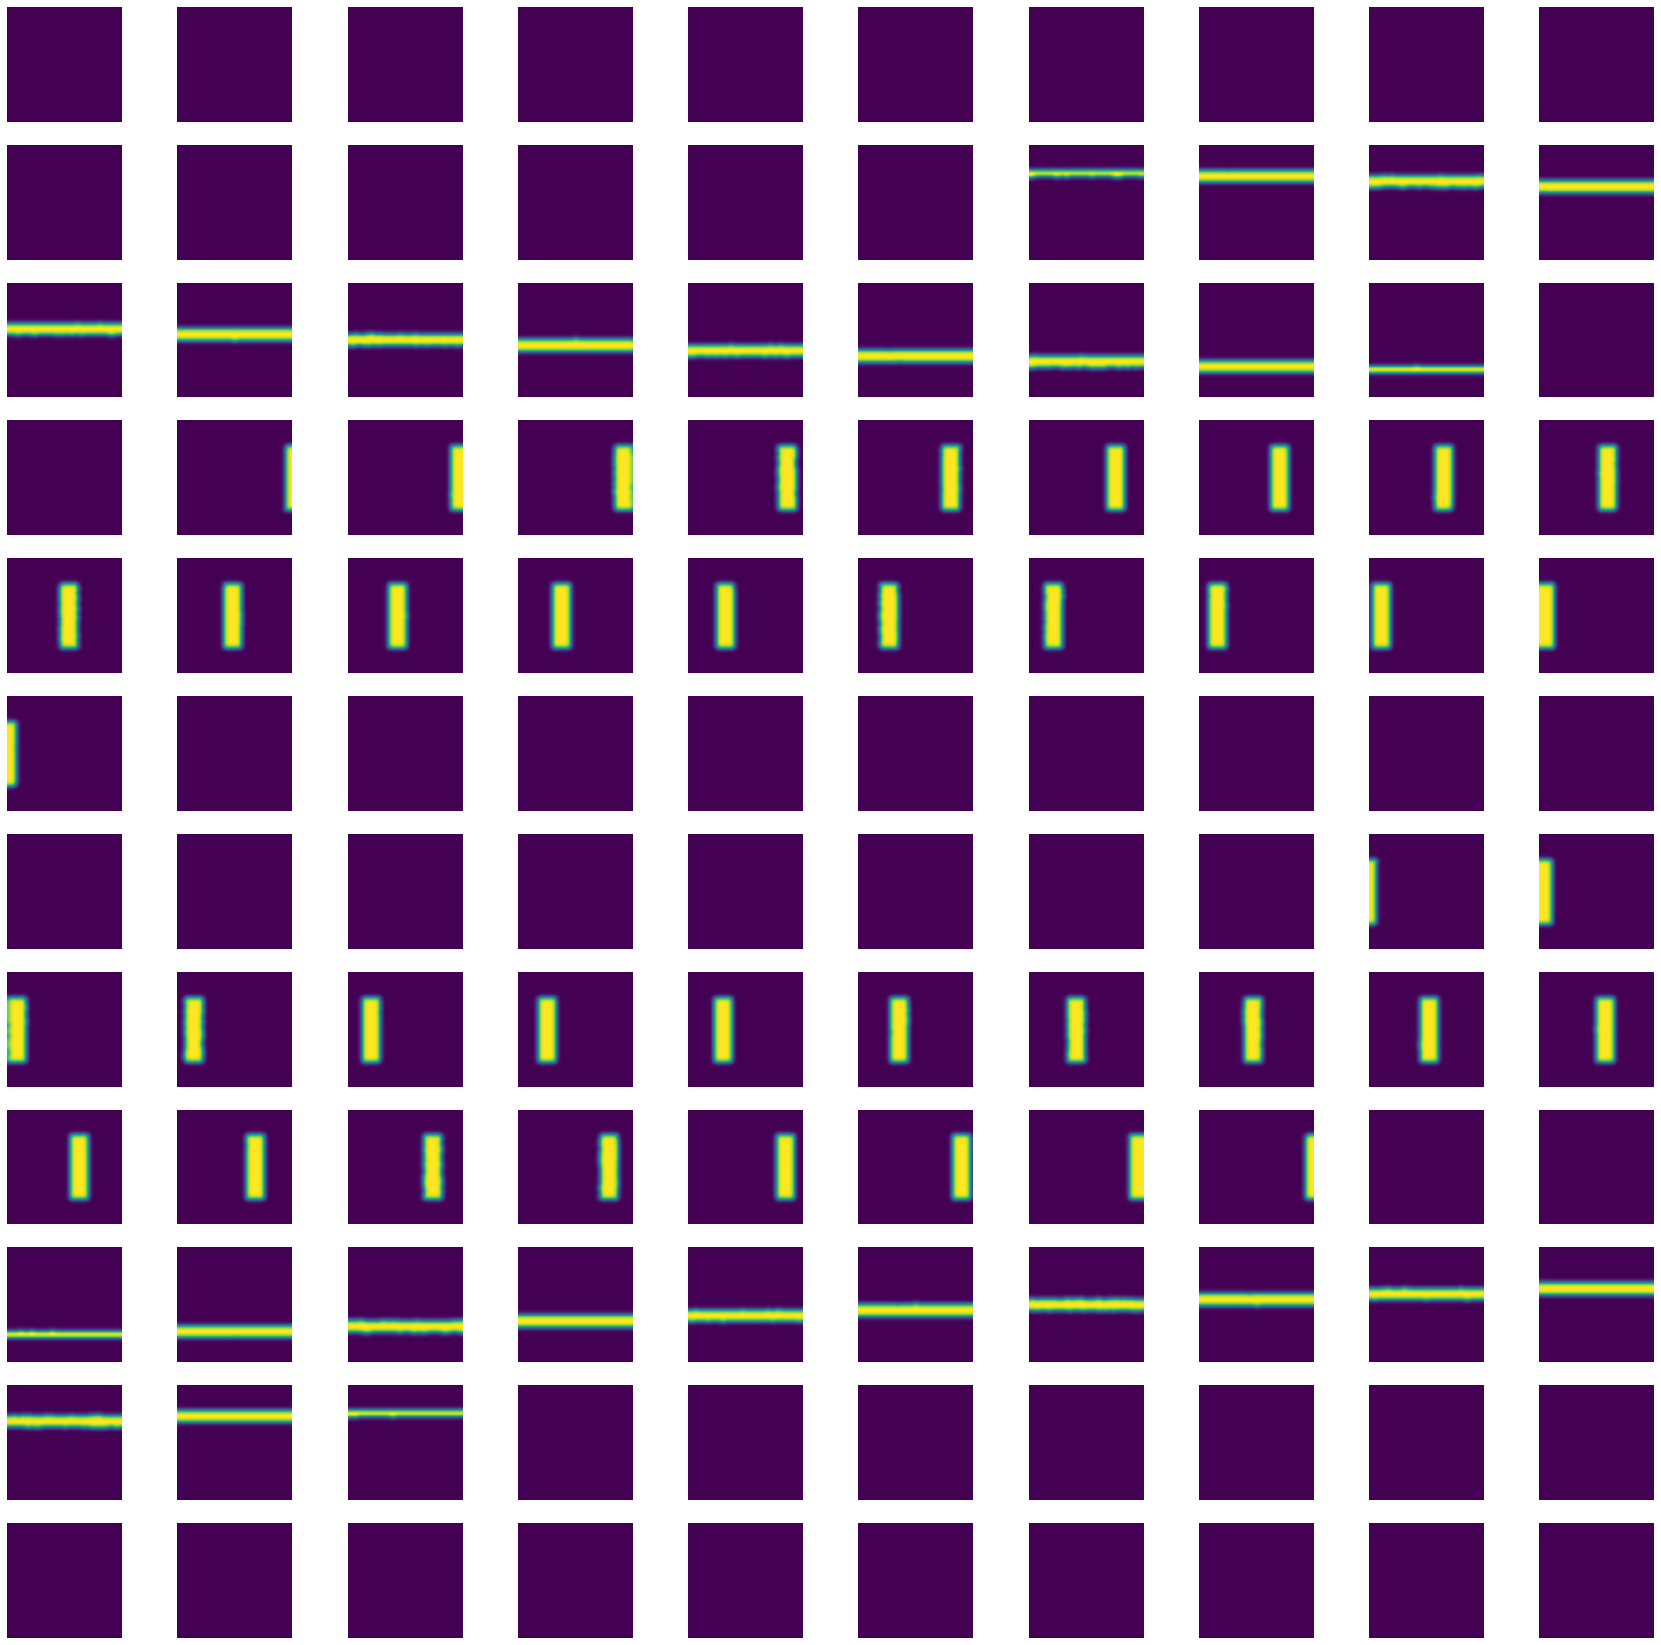

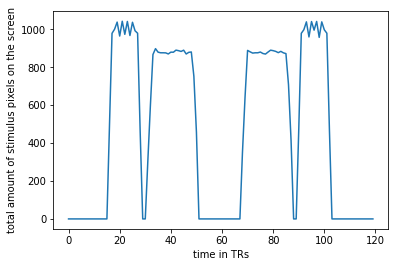

In [78]:
from scipy.io import loadmat
from scipy.ndimage import median_filter, gaussian_filter, binary_propagation
import matplotlib.animation as animation

dms = loadmat('/content/data/prf_mapper_59k/vis_design.mat')['stim'].T

# we have to do a bit of processing on the design matrix. 
# in essence this is a very slowly sampled movie of where the stimulus was on the screen
# you have one frame per TR, so that the analysis becomes easier. 

pixel_offset = int((dms.shape[1] - dms.shape[2]) / 2)
new_dms = np.zeros((dms.shape[0], dms.shape[1], dms.shape[1]))
for timepoint in range(dms.shape[0]):
    square_screen = np.zeros_like(new_dms[timepoint])
    square_screen[:,pixel_offset:pixel_offset+dms.shape[2]] = (dms[timepoint]!=0).astype(float)
    new_dms[timepoint,:,] = gaussian_filter(square_screen, 10).T

# if we then re-sample this design matrix to the same 100 x 100
# pixel space of our models above, our model space and stimulus space align. 

new_dms = new_dms[:,::5,::5]

# But what does it look like? Let's plot the design we're using!
# we could do this by creating a whole sequence of imshow plots,
# but this turns ugly pretty quickly. 

f, ss = plt.subplots(12,10, figsize=(30,30))
shp = 0
for i in range(12):
    for j in range(10):
        ss[i,j].imshow(new_dms[shp])
        ss[i,j].axis('off')
        shp += 1

# perhaps it's best to try to visualize this as it was in the actual experiment.
# but Google Colab doesn't do interactive plots....

# f, ax = plt.subplots(1, 1, figsize=(8,8))
# ax.axis('off')
# ims = []
# for i in range(new_dms.shape[0]):
#     if i == 0:
#         ax.imshow(new_dms[i])  # show an initial one first
#     im = ax.imshow(new_dms[i], animated=True)
#     ims.append([im])

# ani = animation.ArtistAnimation(f, ims, interval=50, blit=True,
#                                 repeat_delay=1000)

# ani
# by plotting the total amount of stimulus pixels on the screen over time
# we get a handle on the structure of the experiment

sos = new_dms.sum((1,2))
plt.figure()
plt.plot(sos)
plt.xlabel('time in TRs')
plt.ylabel('total amount of stimulus pixels on the screen');

A couple of things are evident from what we see here, and I want to highlight those. Even though we're making a square matrix as a design matrix, you see that the screen we used was a widescreen device (wider than tall). Actually, the screen was fullHD, or 1920x1080 pixels. But using that many pixels in a design matrix would make little sense, it would add a whole bunch of numbers and make the calculations slow. In fact, we're not doing anything with that level of precision: the great majority of pRFs in cortex have a larger $\sigma$ than 0.5 degrees of visual angle, so that's more than 100 voxels across. So, it's quite reasonable if we reduce the size of our stimulus array to 100x100. You've noticed, I'm sure; we're making the stimulus movie square, now. It's no accident that this is exactly the same size as the pRF models we created above. Indeed, this makes the stimulus design matrix and the model parameters fit completely: our models are defined in degrees of visual angles, and our stimulus lives in this same space: the screen was 20 degrees wide, fitting with the `space1D` variable we defined up there. If you were to run your own pRF experiment and analysis, you'd have to take a lot of care that all of these align, but our 100x100 design matrix and model dimensions take care of this for you. 

### Combining pRF model with our Stimulus

Now that we have our pRF model and our Stimulus in the same space, we can start to apply the pRF to the stimulus to create a model-predicted time-course. We'll walk through a couple of example pRFs.

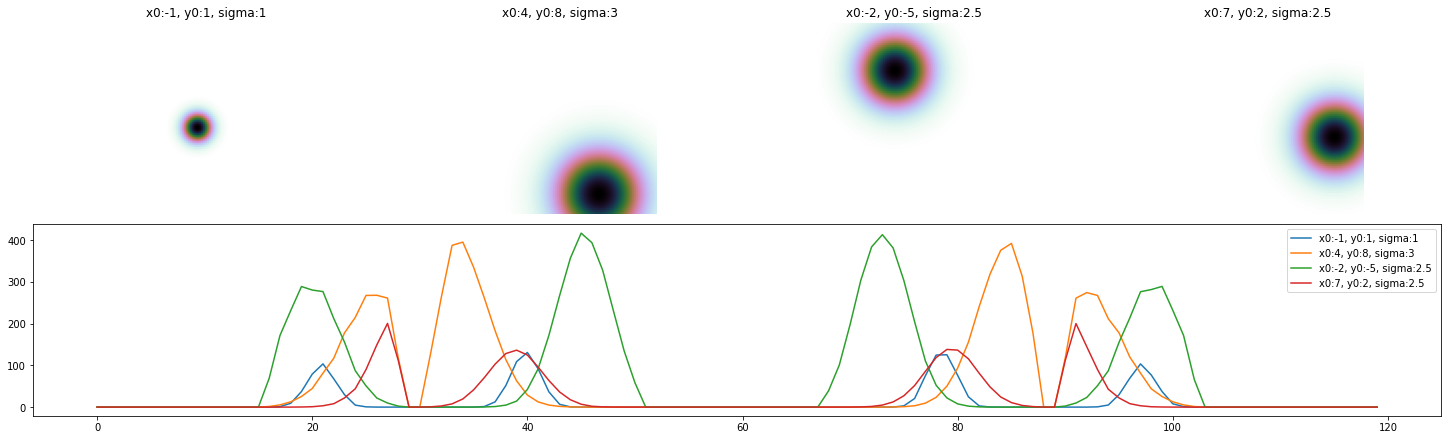

In [79]:
# For clarity of the calculation, we make a vector out of the images 
# of both the stimulus and the pRF model by raveling them. 

def model_timecourse(model, stimulus):
    return np.dot(model.ravel(), stimulus.T.reshape((-1,stimulus.shape[0])))

# and we can plot these for a bunch of different pRFs
# and to make it nice, we use a gridspec. Remember this for your report :)
from matplotlib.gridspec import GridSpec

fig = plt.figure(constrained_layout=True, figsize=(20,6))
gs = GridSpec(2, 4, figure=fig)
ax_tc = fig.add_subplot(gs[1,:])

for x0,y0,sigma,i in zip([-1,4,-2,7], [1, 8, -5, 2], [1, 3, 2.5, 2.5], [0,1,2,3]):
    pRF = gauss2D_iso_cart(X, Y, mu=(x0,y0), sigma=sigma, normalize_RFs=False)
    ax_prf = fig.add_subplot(gs[0,i])
    ax_prf.imshow(pRF, cmap='cubehelix_r')
    ax_prf.set_title(f'x0:{x0}, y0:{y0}, sigma:{sigma}')
    ax_prf.axis('off')
    ax_tc.plot(model_timecourse(pRF, new_dms), label=f'x0:{x0}, y0:{y0}, sigma:{sigma}')
ax_tc.legend();

You see how these predict completely different timecourses of the signals? So, just by varying the parameters of the model, we can create vastly different timecourses. This also means that we can fit the model to our data, even if  very different timecourses exist in our data: one model to capture them all! Even nicer: the differences between these model timecourses are generated by changing just 3 parameters! 

### Grid Search

To find the optimal parameters settings to explain the brain time-courses, our first (and, for this project, only) analysis step is to create a grid of predictions, and fit them to the data. We'll then find the best-fitting model out of all models we tried. 

In [80]:
# first, we'll get some data from a single ROI:

ROI_tcs = hpfiltered[atlas_data_both_hemis == roi_index_dict['V1']]

# then, we'll define the grid of possible pRF parameters that we want to try out.
# we have to be very careful in changing the amount of different grid points, 
# since computation time goes with the cube of this number.
n_grid_points = 15
xes, yes, sizes = np.linspace(-10,10,n_grid_points,endpoint=True), np.linspace(-10,10,n_grid_points,endpoint=True), np.linspace(0.25,10,n_grid_points,endpoint=True)
xgrid, ygrid, sgrid = np.meshgrid(xes, yes, sizes)
xgrid, ygrid, sgrid = xgrid.ravel(), ygrid.ravel(), sgrid.ravel()

# this will then allow us to create model time-courses for all of these. 
# this operation is rather computationally expensive, but for the grid fit, 
# it's the most time-consuming step (if we maintain a moderate number of grid points!)

grid_model_timecourses = np.array([model_timecourse(np.rot90(gauss2D_iso_cart(X, Y, mu=(x0,y0), sigma=sigma, normalize_RFs=False)), new_dms) for x0,y0,sigma in zip(xgrid, ygrid, sgrid)])
print(f'{grid_model_timecourses.shape[0]} grid_model_timecourses created!')

3375 grid_model_timecourses created!


That took a while, right? Let's take care of these model time-courses so that we don't have to re-compute them. But, we're still missing something. We have a model but it predicts neural population time-courses instead of BOLD signal time-courses. You know what to do, right? Luckily, the entire pRF experimental design is discretized on the TR: the bar stimulus jumps whenever an new TR starts. This means no ugly stuff in resampling the HRF relative to the time-points. 

For our HRF definition, we'll use a standard model which we'll steal from a package we're already importing. I know from experience that the 7T HRF looks a bit different, though, so it makes sense to shift it by half a TR (See that `onset=-tr/2`?)

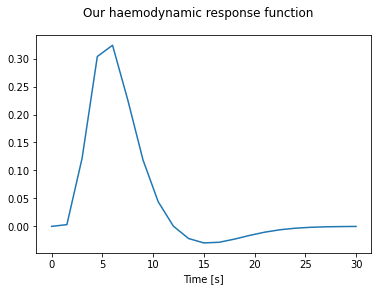

In [81]:
from nilearn.glm.first_level.hemodynamic_models import _gamma_difference_hrf
tr = 1.5

hrf = _gamma_difference_hrf(tr=tr ,oversampling=1, onset=-tr/2)[np.newaxis,:]
plt.plot(np.arange(hrf.shape[-1])*tr, hrf.ravel())
plt.suptitle('Our haemodynamic response function')
plt.xlabel('Time [s]')

# and we perform the actual convolution in a fast way. 
grid_model_timecourses_conv = sp.signal.fftconvolve(grid_model_timecourses, hrf, mode='full', axes=(-1))[..., :grid_model_timecourses.shape[-1]]

### Bringing it all together for a single voxel

If you look back at the computational workflow figure on the right when we introduced the pRF model, you can see that we now have all the ingredients for our analysis to take place. The grid search procedure changed the layout of the diagram a bit, but all the ingredients are there. Please have a look and check. 

In the following code, we'll be putting the different steps together, and you'll be surprised: The workhorse behind this analysis is the same method that powered the first notebook on the GLM: `np.linalg.lstsq`! The difference now is that we're going to do a whole sequence of GLMs, one for each model. It's a simple model, with only a single actual timecourse regressor, but a GLM nonetheless!

In [82]:
def rsq_for_model(data, model_tcs, return_yhat=False):
    """
    Parameters
    ----------
    data : numpy.ndarray
        1D or 2D, containing single time-course or multiple
    model_tcs : numpy.ndarray
        1D, containing single model time-course
    Returns 
    -------
    rsq : float or numpy.ndarray
        within-set rsq for this model's GLM fit, for all voxels in the data
    yhat : numpy.ndarray
        1D or 2D, model time-course for all voxels in the data

    """
    dm = np.vstack([np.ones(data.shape[-1]), model_tcs]).T
    betas = np.linalg.lstsq(dm, data.T)[0]
    yhat = np.dot(dm, betas).T
    rsq = 1-(data-yhat).var(-1)/data.var(-1)
    if return_yhat:
        return rsq, yhat
    else:
        return rsq

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


BFM =  1846


Text(0.5, 1.0, 'profile of best-fitting pRF model')

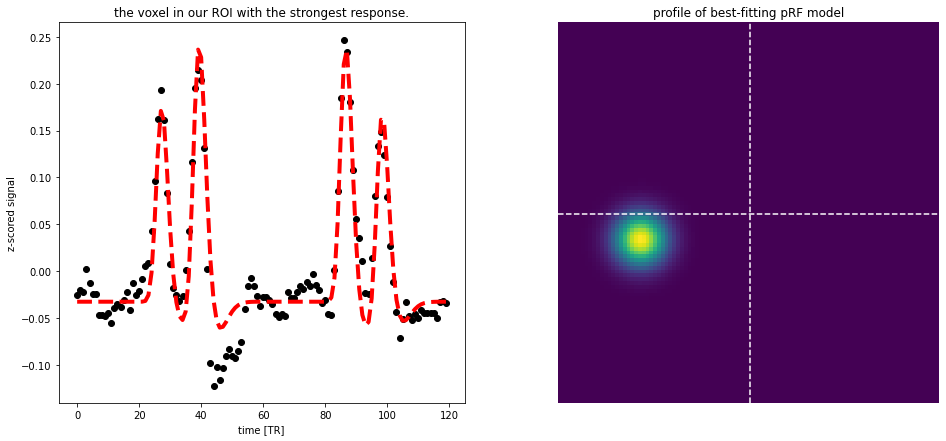

In [83]:
# let's first exemplify the whole thing with a single BOLD time-course 
# This we'll first inspect a bit.

sv_tcs = ROI_tcs[np.argmax(ROI_tcs.std(1))] # <- select the voxel with the strongest response
f, sps = plt.subplots(1,2,figsize=(16,7))
sps[0].plot(sv_tcs, 'ko', label='data')
sps[0].set_ylabel('z-scored signal')
sps[0].set_xlabel('time [TR]')
sps[0].set_title('the voxel in our ROI with the strongest response.')

rsqs = np.array([rsq_for_model(sv_tcs, mtcs) for mtcs in grid_model_timecourses_conv])
best_fitting_model = np.argmax(rsqs)
print('BFM = ', best_fitting_model)

x0, y0, sigma = xgrid[best_fitting_model], ygrid[best_fitting_model], sgrid[best_fitting_model]
# # re-run the model fit for the best-fitting model to look at its time-course
yhat = rsq_for_model(sv_tcs, grid_model_timecourses_conv[best_fitting_model], return_yhat=True)
sps[0].plot(yhat[1], 'r--', lw=4, label='model fit')

sps[1].imshow(gauss2D_iso_cart(X, Y, mu=(x0,y0), sigma=sigma, normalize_RFs=False))
sps[1].axvline(50, color='w', ls='--')
sps[1].axhline(50, color='w', ls='--')
sps[1].axis('off')
sps[1].set_title('profile of best-fitting pRF model')
# feel free to try this out with a different vertex from our ROI!

Great. You've performed an actual pRF fit on the voxel with the highest standard deviation. But was that all? No! we recorded these timecourses throughout the brain so we'll try to fit them all. Well, at first we'll do this per ROI. The `rsq_for_model` function is set up such that you can also push in an entire 2D dataset. Just keep in mind that this is going to take a lot more time to compute - that's also why we're not doing the whole brain at once. 

In [167]:
# %%timeit
# fitting for the entire ROI at once. It will give us a large output:
# an rsq array of nr_vertices by nr_models. 
# for the entire brain (or for a more finely spaced parameter space) 
# that would be a very large array to keep in memory, 
# so we'll do this on a per-ROI basis.
# if you can write a routine that makes this possible nonetheless, 
# that's part of the advanced questions for the report (see below)

rsqs = np.array([rsq_for_model(ROI_tcs, mtcs) for mtcs in grid_model_timecourses_conv])
rsqs
best_fitting_models = np.argmax(rsqs, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [162]:
np.max(rsqs)
print(rsqs)
rsqs = copy_rs

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [115]:
rsqs[rsqs < 0.15] = -100000
print(rsqs)
print(np.max(rsqs[:,1]))
best_fitting_models = np.argmax(rsqs, axis=1)


[[-100000. -100000. -100000. ... -100000. -100000. -100000.]
 [-100000. -100000. -100000. ... -100000. -100000. -100000.]
 [-100000. -100000. -100000. ... -100000. -100000. -100000.]
 ...
 [-100000. -100000. -100000. ... -100000. -100000. -100000.]
 [-100000. -100000. -100000. ... -100000. -100000. -100000.]
 [-100000. -100000. -100000. ... -100000. -100000. -100000.]]
0.9432969262837131


In [142]:
def _nanargmax(arr, axis):
  result = np.zeros((arr.shape[1]))
  print(result.shape)
  for i in range(result.shape[0]):
    try:
      result[i] = np.nanargmax(arr[:,i], axis=0)
    except ValueError:
      result[i] = np.nan
  return result

In [131]:
rsqs.shape

(3375, 2939)

In [158]:
rsqs[rsqs < 0.15] = np.nan
print(rsqs)
print(np.nanmax(rsqs))

best_fitting_models = _nanargmax(rsqs, axis=1)


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
0.9432969262837131
(2939,)


In [148]:
print(best_fitting_models)
print(best_fitting_models.shape)
print(np.nanmax(best_fitting_models))

[nan nan nan ... nan nan nan]
(2939,)
3371.0


### Visual Field Parameters

Well, that's great - we have a well-fitting model! And even for each voxel/vertex in V1! But what we're really interested in is what this voxel represents: a specific visual field location! 

To check this out, we can plot the pRF in the visual field, like we did a couple of cells back. But in the report you'll want to describe the results of fitting on more than one voxel, more at the level of an entire ROI. At that point it becomes easier to inspect the model parameters across the population of voxels/vertices. These informative measures you can then plot in scatter plots (for all voxels in an ROI, for example), or onto the flatmap (by filling in the full cortex according to the binary ROI mask you used to select the timecourses in the first place). Whenever you do this, make sure to take explained variance into account. Specifically, in this experiment, we don't want to be looking at voxels with an rsq lower than 0.15 or so, so you should convert all measures in these badly fitting voxels to `np.nan`. This will prevent them from being rendered on the flatmap.

In [159]:
best_fitting_models = np.expand_dims(best_fitting_models, axis= 1)
best_fitting_models = best_fitting_models.astype(int)
print(best_fitting_models.shape)

(2939, 1)


In [168]:
# once we have the best-fitting model for the different vertices/voxels, 
# we can look up what their visual field parameters are. This means that
# for each voxel/vertex, we now have an rsq and everything we need to 
# plot the voxel's pRF!

x_y_s = np.array([[xgrid[bfm], ygrid[bfm], sgrid[bfm]] for bfm in best_fitting_models])
x_y_s.shape

(3375, 3)

**Units**

Because of the organization of the visual system, we'll now want to convert the parameters of the best-fitting model from x0 and y0 to eccentricity and polar angle, as you saw in the Dumoulin 2008 paper. The functions to do this are given below: 

In [89]:
# But working with polar coordinates is a bit hairy.
# The easiest way to go is through complex numbers. 
# you don't need to understand the following completely, 
# but you can use the code. It will also take arrays for 
# x0 and y0.

def angle(x0, y0):
    return np.angle(x0 + y0 * 1j)

def ecc(x0, y0):
    return np.abs(x0 + y0 * 1j)

To plot polar angle on the surface, you should use a circular colormap because phase is a circular measure. Please see the pycortex website for a collection of colormaps: https://gallantlab.github.io/pycortex/colormaps.htm

In [165]:
print(best_fitting_models)
x_y_s


[[-9223372036854775808]
 [-9223372036854775808]
 [-9223372036854775808]
 ...
 [-9223372036854775808]
 [-9223372036854775808]
 [-9223372036854775808]]


array([[-10.        , -10.        ,   0.25      ],
       [  4.28571429,  -7.14285714,   8.60714286],
       [  4.28571429,  -7.14285714,   8.60714286],
       ...,
       [ 10.        ,  -1.42857143,  10.        ],
       [-10.        ,   0.        ,   0.25      ],
       [-10.        ,   0.        ,   0.25      ]])

So now we have the coordinates in x_y_s! 


We use these to reconstruct our data:

In [170]:
flattened_coords = [gauss2D_iso_cart(x= xys[0], y = xys[1], sigma = xys[2]) for xys in x_y_s]

In [171]:
flattened_coords

[0.003940955076160474,
 0.6260584785605283,
 0.6260584785605283,
 0.6544558154014597,
 0.6544558154014597,
 0.6544558154014597,
 0.535525156678993,
 0.6006433515159182,
 0.6006433515159182,
 0.6006433515159182,
 0.6006433515159182,
 0.4419035916540212,
 0.4419035916540212,
 0.7068486033780922,
 0.06649951293301964,
 0.003940955076160474,
 0.6260584785605283,
 0.6544558154014597,
 0.6544558154014597,
 0.6544558154014597,
 0.535525156678993,
 0.535525156678993,
 0.535525156678993,
 0.535525156678993,
 0.4419035916540212,
 0.4419035916540212,
 0.4419035916540212,
 0.4419035916540212,
 0.49370695042878354,
 0.49370695042878354,
 0.003940955076160474,
 0.6544558154014597,
 0.6544558154014597,
 0.535525156678993,
 0.535525156678993,
 0.535525156678993,
 0.535525156678993,
 0.535525156678993,
 0.4419035916540212,
 0.4419035916540212,
 0.4419035916540212,
 0.4419035916540212,
 0.49370695042878354,
 0.49370695042878354,
 0.49370695042878354,
 0.003940955076160474,
 0.3592454273310757,
 0.359245

## Your task

Ok, now you have all the ingredients to perform a full pRF analysis on the data you have. You should be able to perform the grid-search pRF fitting across voxels/vertices, and plot the results on the surface. 

**Your goal is to replicate Figures 5, 6, and 8 from the original Dumoulin 2008 paper, and describe these results in detail in the report.**

Your best bet is to start with just the first 3 visual regions, V1, V2, and V3. A passing grade, say, a 6.5 to 7.5 can be attained by a `sec` replication of these 3 figures of the original pRF paper, and a thorough and insightful discussion of the similarities and deviations from the original (the exact grade depending on the writing). Note that you aren't expected to produce 3D plots of the cortical surface, but you should make your plots on the flatmap you've been using. This will make Figure 5 look more like the figure on the right: 
<img style="float:right; align:right top; margin:10px; padding: 25px 25px 25px 25px;" src="https://i.imgur.com/laYGGmS.png" alt="Example of retinotopy on flatmap" width="300" align="right" />

Then, there is a sequence of additional steps that can get you to a higher grade. They are ordered according to increasing difficulty. 

1. Perform fitting on more visual regions, as listed in the ROI dictionary. With these results you can create ROI-based plots cf. Figure 8, as well as fill in the surface plots even further. Answer the following questions: 
  - do the borders between these regions from the atlas line up with polar angle reversals, just like in V1, V2, V3? Can you speculate why is that (not) the case?
2. np.linalg.lstsq can fit on 2D data, that is, the whole brain simultaneously. That means that with slight changes to the explanatory code above you can speed up your fitting and show results for the entire brain, even! If you manage to do this, plot the rsq of the best-fitting model throughout the brain. You should also be able to see that there are large regions in frontal cortex that are retinotopic!
3. In the original paper, the authors describe the effects of changing the HRF to pRF fits. Since the experiment of the HRF mapper project was run on the same subject as the pRF experiment (Tomas), this means that you can now perform that project's estimation of HRF shape per vertex, and check whether this changes the fit quality in V1, V2, and V3. The way to do this is to estimate the mean HRF shape for V1, V2, and V3 and then use those to fit the pRFs from those regions. You don't need to go further than these regions since our HRF mapper didn't activate much higher than V3.
4. A more recent addition to the original model adds a nonlinearity to the model (the original model is a linear model). That is, the model's timecourse $s$ is converted to $s^n$, where $n$, the exponent, has a value between 0 and 1. Read [this paper](http://kendrickkay.net/papers/KayJNeurophysiology2013.pdf) and implement its model, perform its fits using a grid fit procedure and check whether this model improves fits differentially across different ROIs, similar to their Figure 6 & 7B. 

**Note:** TBH, I don't expect any of you to pull of number 4, and number 3 is already advanced bonus material. But it will give you something to aim for, because it does give you an example of the type of work we do in the lab. 


# Report Outline

This part of the notebook outlines the sections we expect your report to contain. You can use this part as a to-be-filled-in template for your project report. The total text should not be too long, so that you don't needlessly pain your long-suffering colleagues. Say, 2000 words max. 



## Title 

a title is more important than you think - a good title draws the reader in. An excellent title is a bit playful without going over the top. Before you finish the report, spend a few minutes brainstorming on the perfect title. It pays off.

## Abstract

An abstract is a brief (say, around 200 words) summary of the research, methods, as well as the findings and their significance. 

## Introduction

Why this research? What does this specific experiment teach us about the brain? Be sure to discuss the articles that go with your project, and any and all additional articles that you've found. Feel free to add figures from published articles to clarify the approach. 

## Methods 

In the methods section, you should describe the experiment and your analyses in as much detail as possible, or at least to the level of detail required for others to replicate your findings. Clearly you don't have all the information regarding scanning parameters, etc, so we won't fault you for not including those here. 

## Results

It's easiest to base your results section around a few (say, 4 or 5) key figures that illustrate what you've done and what you've found. These can be illustrations, flatmaps, time-courses and/or anything that you decide is a cool visualization of your results. You can start with a description of the data as you're getting it, basing yourself on the *Questions concerning signal quality* etc. above. 

Be sure to describe your figures with adequate captions. For these results, we will focus on qualitative descriptions and not so much on hard stats - which are harder to do on single subjects. 

I hope you will have fun creating this project and I also hope that your findings will reflect the fun you have. 

## Discussion

*   What have we learned? 
*   What should others be aware of? 
*   In what sense do your findings correspond to the literature you know, and in what sense do your findings deviate from the canon? 

What have you learned?

Feel free to add references that you've stumbled upon yourselves. 